# plot_inst.ipynb

Author: Robert M. Frost

University of Oklahoma

Created 28 December 2022

Purpose: Read in netCDF files output by LESnc.py to plot 
vertical profiles of fluxes, variances, TKE, and other 
turbulence statitics

## Imports

In [13]:
import os
import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator

## Loading in data

In [14]:
# directory for netCDF simulation output
dnc = "/share/temp/rfrost/simnc/"
# list of simulations to loop over
sims = ["full_step_9"]
# directory for figures to be saved
dout = "/home/rfrost/figures/"
# height to plot (z/h)
height = 0.25

# first timestep of simulation
t0 = 576000
# final timestep of simulation
t1 = 1152000
# output frequency in timesteps
dt = 1000
# dimensionsal timestep in seconds
delta_t = 0.05

# timesteps to be analyzed in hours
tload = np.arange(9, 16, 1)

In [15]:
# empty list to construct paths and store
dnc_all = []
for sim in sims:
    dnc = f"{dnc}{sim}/"
    dnc_all.append(dnc)

Arrange timesteps

In [16]:
timesteps = np.arange(t0, t1+1, dt, dtype=np.int32)
t = (delta_t * timesteps) / 3600. # convert timesteps to hours
# grab the timesteps for loading
# array of times
tload = np.array(tload) # hrs
# loop to find nearest timestep
jt1 = np.array([np.argmin(np.abs(t - tt)) for tt in tload])
# number of timesteps
nt = len(tload)

Construct dataframes

In [17]:
# Case 1
# construct filenames
df_all = []
for sim in range(len(sims)):
    f = [f"{dnc_all[sim]}all_{timesteps[jt]:07d}.nc" for jt in jt1]
    # load mf dataset
    df = xr.open_mfdataset(f, combine="nested", concat_dim="time")
    df.coords["time"] = t[jt1]
    df.time.attrs["units"] = "hr"
    df_all.append(df)

Calculate statistics

In [18]:
# calculate "inst" covar based on xy planar averages
for i, s in enumerate(df_all):
    # averages and perturbations
    for v in ["u", "v", "w", "theta"]:
        s[f"{v}_mean"] = s[v].mean(dim=("x", "y"))
        s[f"{v}_pert"] = s[v] - s[f"{v}_mean"]
    # covars
    s["uw"] = (s.u - s.u_mean) * (s.w - s.w_mean) + s.txz
    s["vw"] = (s.v - s.v_mean) * (s.w - s.w_mean) + s.tyz
    s["tw"] = (s.theta - s.theta_mean) * (s.w - s.w_mean) + s.q3
    # vars
    s["uu"] = (s.u - s.u_mean) * (s.u - s.u_mean)
    s["vv"] = (s.v - s.v_mean) * (s.v - s.v_mean)
    s["ww"] = (s.w - s.w_mean) * (s.w - s.w_mean)
    s["tt"] = (s.theta - s.theta_mean) * (s.theta - s.theta_mean)

    # calculate averages
    s["uw_cov_tot"] = s.uw.mean(dim=("x","y"))
    s["vw_cov_tot"] = s.vw.mean(dim=("x","y"))
    s["tw_cov_tot"] = s.tw.mean(dim=("x","y"))
    s["uu_var"] = s.uu.mean(dim=("x","y"))
    s["vv_var"] = s.vv.mean(dim=("x","y"))
    s["ww_var"] = s.ww.mean(dim=("x","y"))
    s["tt_var"] = s.tt.mean(dim=("x","y"))

    # calculate ustar
    s["ustar"] = ((s.uw_cov_tot**2) + (s.vw_cov_tot**2))**0.25
    s["ustar0"] = s.ustar.isel(z=0)
    s["ustar2"] = ((s.uw_cov_tot**2) + (s.vw_cov_tot**2.)) ** 0.5

    # calulcate z_i
    idx = s.tw_cov_tot.argmin(axis=1)
    s["zi"] = s.z[idx]

    # calulate obukhov length
    s["theta_mean"] = s.theta.mean(dim=("x","y"))
    s["L"] = -1*(s.ustar0**3) * s.theta_mean.isel(z=0) / (.4 * 9.81 * s.tw_cov_tot.isel(z=0))
    # calculate -zi/L
    s["zi_L"] = -1*(s.zi / s.L)

    # calculate wstar
    s["wstar"] = ((9.81/s.theta_mean.isel(z=0))*s.tw_cov_tot.isel(z=0)*s.zi)**(1/3)

    # calculate TKE
    s["tke"] = (1/2) * (s.uu + s.vv + s.ww)

## Plotting

In [19]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')
cmap = seaborn.color_palette("Spectral", as_cmap=True)
cmap2 = seaborn.color_palette("cubehelix_r", as_cmap=True)

### $w'$ cross section

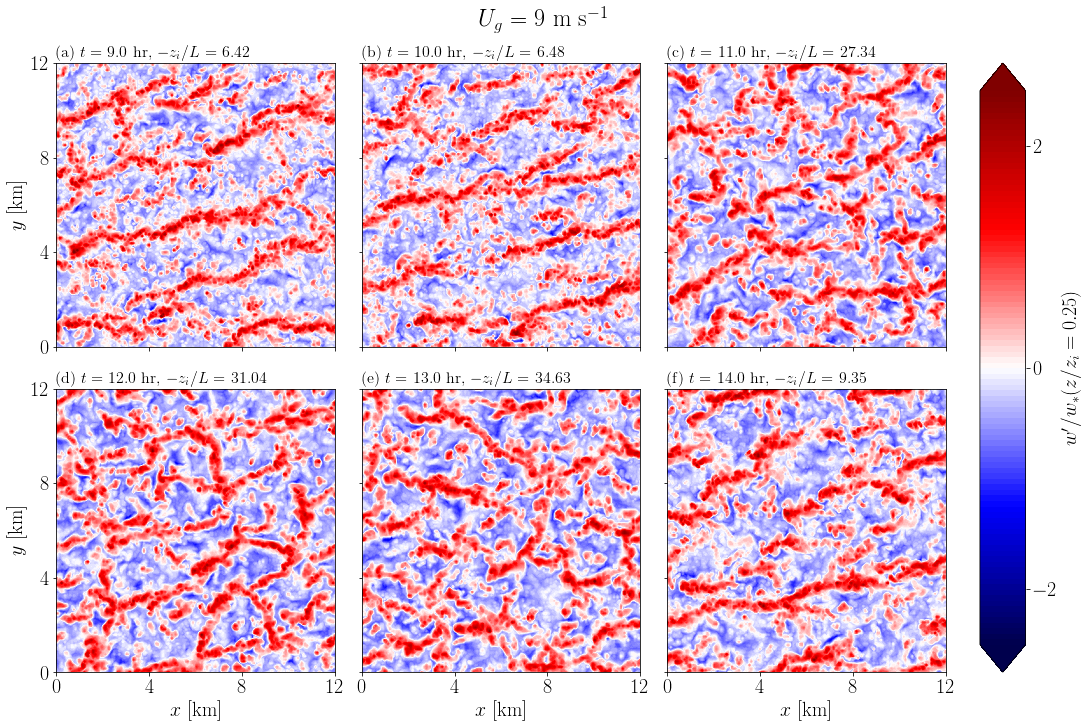

In [20]:
# loop over sims and plot for z = 100 m
# jz = abs(d1.z - 100.0).argmin()
# sim to plot
sim = 0
# make 6-panel plot
fig4, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True,
                        constrained_layout=True, figsize=(15, 10))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelw = np.linspace(-2.5, 2.5, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax.flatten()):
    # calc z/zi
    # calculate zi
    jzi = df_all[sim].tw_cov_tot.isel(time=jt).argmin().values
    zzi = df_all[sim].z/df_all[sim].z[jzi]
    jz = abs(zzi - height).argmin()
    # contour
    cfax = iax.contourf(df_all[sim].x/1000, df_all[sim].y/1000, df_all[sim].w_pert.isel(time=jt, z=jz).T / df_all[sim].wstar.isel(time=jt),
                        levels=levelw, cmap=mpl.cm.seismic, extend="both")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig4.colorbar(cfax1[0], ax=ax[:,-1], location="right", ticks=MultipleLocator(2))
# cb label
cb.ax.set_ylabel(f"$ w' / w_*  (z/z_i={height})$")# [m s$^{{{-1}}}$]")
# axis limits
ax[0,0].set_xlim(0, 12)
ax[0,0].set_ylim(0, 12)
# axis ticks
ax[0,0].xaxis.set_major_locator(MultipleLocator(4))
ax[0,0].yaxis.set_major_locator(MultipleLocator(4))
# axis labels
for iax in ax[:,0]:
    iax.set_ylabel("$y$ [km]")
for iax in ax[1,:]:
    iax.set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax.flatten(), list("abcdef"))):
        iax.set_title(f"({lab}) $t =$ {df_all[sim].time[jt].values.round(2)} hr, $-z_i / L$ = {df_all[sim].zi_L.isel(time=jt).values.round(2)}", fontsize=16, loc="left")
# plot title
fig4.suptitle("$U_g$ = 9 m s$^{-1}$")
# plt.suptitle(f"$U_g$ = {ug[sim]} [m s$^{{{-1}}}$]")
# save figure
# fsave = f"{figdir}agu1_w_zzi_6panel.png"
# fig1.savefig(fsave, dpi=900)
plt.show(fig4)
plt.close(fig4)

### $\theta ' w'$ cross section

In [22]:
# # loop over sims and plot for z = 100 m
# jz = abs(df_all[0].z - 100.0).argmin()
# # make 6-panel plot
# fig3, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, 
#                          constrained_layout=True, figsize=(10, 6.1))
# # keep track of cfaxis handles
# cfax1 = []
# # define cbar range
# leveltw = np.linspace(-3, 3, 101)
# # loop over timesteps and plot in each panel
# for jt, iax in enumerate(ax.flatten()):
#     # contour
#     cfax = iax.contourf(df_all[0].x/1000, df_all[0].y/1000, df_all[0].tw.isel(time=jt, z=jz).T,
#                         levels=leveltw, cmap=cmocean.cm.balance, extend="both")
#     # keep cf handle
#     cfax1.append(cfax)
#     # cb = fig1.colorbar(cfax, ax=iax, location="right")
# # one big colorbar on the right
# cb = fig3.colorbar(cfax1[0], ax=ax[:,-1], location="right", ticks=MultipleLocator(1))
# # cb label
# cb.ax.set_ylabel("$\\langle \\theta' w' \\rangle$ [K m s$^{-1}$]")
# # axis limits
# ax[0,0].set_xlim([0, 12])
# ax[0,0].set_ylim([0, 12])
# # axis ticks
# ax[0,0].xaxis.set_major_locator(MultipleLocator(4))
# ax[0,0].yaxis.set_major_locator(MultipleLocator(4))
# # axis labels
# for iax in ax[:,0]:
#     iax.set_ylabel("$y$ [km]")
#     iax.set_title(f"")
# for iax in ax[-1,:]:
#     iax.set_xlabel("$x$ [km]")

# plt.show(fig3)
# plt.close(fig3)

## Time averaged data

Reading in calc_stats_tz data set

In [23]:
df_all = []
for sim in sims:
    df = xr.load_dataset(f"{dnc}/{t0}_{t1}_stats.nc")
    df_all.append(df)

for i, s in enumerate(df_all):
    # convert time to hours
    s["time"] = (s.time / 3600.) + (t0 * delta_t) / 3600.
    # tke
    s["tke"] = (1/2) * (s.uu_var + s.vv_var + s.ww_var)
    # ustar^2
    s["ustar2"] = ((s.uw_cov_tot**2) + (s.vw_cov_tot**2.)) ** 0.5

avg=36
jt1 = ((np.array([np.argmin(np.abs(t - tt)) for tt in tload]).astype(int))).astype(int)
colors1 = seaborn.color_palette("rocket_r", len(jt1))

### 1 x 3 convergence test

30 minute averaged data

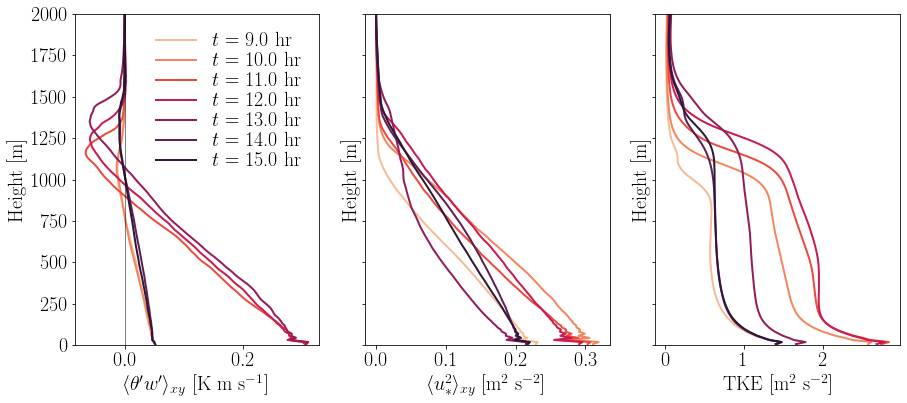

In [24]:
fig2, ax = plt.subplots(ncols=3, figsize=(13,6), sharey=True)
# loop over timesteps
for i in range(len(jt1)):
    # (a) theta'w'
    ax[0].plot(df_all[0].tw_cov_tot.isel(time=jt1[i]), df_all[0].z,
                label=f"$t$ = {((jt1[i] * delta_t * dt) + (t0 * delta_t)) / 3600} hr",
                lw=2, c=colors1[i])
    # (b) u*^2 rolling mean
    ax[1].plot(df_all[0].ustar2.coarsen(time=avg, boundary="trim").mean().isel(time=(jt1[i]/avg).astype(int)),
                df_all[0].z, lw=2, c=colors1[i])
    # (c) tke rolling mean
    ax[2].plot(df_all[0].tke.coarsen(time=avg, boundary="trim").mean().isel(time=(jt1[i]/avg).astype(int)),
                df_all[0].z, lw=2, c=colors1[i])

# clean up
for iax in ax:
    iax.set_ylabel("Height [m]")
# (a)
ax[0].set_xlabel("$\\langle \\theta ' w' \\rangle_{xy}$ [K m s$^{-1}$]")
ax[0].legend(frameon=False, labelspacing=0.05, loc="upper right")
ax[0].axvline(0, ls="-", c="k", lw=0.5)
# (b)
ax[1].set_xlabel("$\\langle u_{*}^{2} \\rangle_{xy}$ [m$^2$ s$^{-2}$]")
# (c)
ax[2].set_xlabel("TKE [m$^2$ s$^{-2}$]")
# fig
plt.ylim(0,2000)
plt.tight_layout()
plt.show(fig2)
plt.close(fig2)